# Accumulated Precipitation

### Libs

In [1]:
import pandas as pd
import re
import time
from functools import wraps
import os
import numpy as np
import plotly.graph_objects as go
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

### Paths

In [2]:
folder_path = r'C:\Users\Win10\Desktop\BTG_Energy\btg-energy-challenge\forecast_files'
contour_path = r'PSATCMG_CAMARGOS.bln'

### Data Processing

In [3]:
def read_data_file(file_path: str) -> pd.DataFrame:
    with open(file_path, 'r') as f:
        raw_file = f.readlines()

    list_dados = [line.split() for line in raw_file]
    float_raw_lines = [list(map(float, raw_line)) for raw_line in list_dados]
    return pd.DataFrame(float_raw_lines, columns=['lat', 'long', 'data_value'])

dataframes = []

for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    df_temp = read_data_file(file_path)
    dataframes.append(df_temp)

combined_df = pd.concat(dataframes, ignore_index=True)

In [4]:
df_acumulado_sum = combined_df.groupby(['lat', 'long'])['data_value'].sum()
df_acumulado_sum = df_acumulado_sum.reset_index()

In [5]:
def read_contour_file(file_path: str) -> pd.DataFrame:
    line_split_comp = re.compile(r'\s*,')

    with open(file_path, 'r') as f:
        raw_file = f.readlines()

    l_raw_lines = [line_split_comp.split(raw_file_line.strip()) for raw_file_line in raw_file]
    l_raw_lines = list(filter(lambda item: bool(item[0]), l_raw_lines))
    float_raw_lines = [list(map(float, raw_line))[:2] for raw_line in l_raw_lines]
    header_line = float_raw_lines.pop(0)
    assert len(float_raw_lines) == int(header_line[0])
    return pd.DataFrame(float_raw_lines, columns=['lat', 'long'])


In [6]:
contour_df: pd.DataFrame = read_contour_file(contour_path)
contour_df.head(3)

,lat,long
0,-44.601813,-22.272547
1,-44.599567,-22.271080
2,-44.592339,-22.270568


### Check map limits

In [7]:
print(contour_df.max())
print(contour_df.min())

lat    -43.888302
long   -21.230853
dtype: float64
lat    -44.749341
long   -22.376971
dtype: float64


## Contour chart - Matplot

In [8]:
filtered_df = df_acumulado_sum.query('-43.75 >= lat >= -45 & -21 >= long >= -22.6')
filtered_df

,lat,long,data_value
7606,-45.0,-22.6,52.6
7607,-45.0,-22.2,79.8
7608,-45.0,-21.8,137.4
7609,-45.0,-21.4,121.3
7610,-45.0,-21.0,112.2
7707,-44.6,-22.6,74.3
7708,-44.6,-22.2,94.3
7709,-44.6,-21.8,125.1
7710,-44.6,-21.4,129.4
7711,-44.6,-21.0,118.7


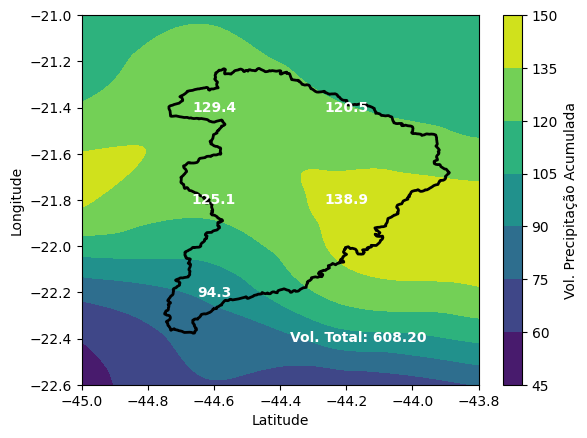

In [9]:
latitudes = filtered_df['lat'].values
longitudes = filtered_df['long'].values
data_values = filtered_df['data_value'].values

grid_x, grid_y = np.mgrid[min(latitudes):max(latitudes):100j, min(longitudes):max(longitudes):100j]
grid_z = griddata((latitudes, longitudes), data_values, (grid_x, grid_y), method='cubic')
plt.contourf(grid_x, grid_y, grid_z, cmap='viridis')

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar(label='Vol. Precipitação Acumulada')
plt.plot(contour_df['lat'], contour_df['long'], linewidth=2, color='black')

fill_spec = filtered_df.query('-43.9 >= lat >= -44.8 & -21.2 >= long >= -22.5 & data_value != 126.39999999999999')
for index, row in fill_spec.iterrows():
    plt.text(row['lat'], row['long'], str(row['data_value']), fontsize=10, color='white', ha='center', va='center', weight='bold')


total_precipitation = np.sum(fill_spec['data_value'])
plt.figtext(0.45, 0.2, f'Vol. Total: {total_precipitation:.2f}', fontsize=10, color='white', weight='bold')
plt.savefig('Contour_chart_Matplot.png')
plt.show()

## Contour Chart Softened - Heatmap (Plotly)

In [10]:
latitudes = filtered_df['lat'].values
longitudes = filtered_df['long'].values
data_values = filtered_df['data_value'].values

grid_x, grid_y = np.mgrid[min(longitudes):max(longitudes):100j, min(latitudes):max(latitudes):100j]
grid_z = griddata((longitudes, latitudes), data_values, (grid_x, grid_y), method='cubic')



heatmap = go.Figure(data=go.Heatmap(
    x=grid_y[0, :],
    y=grid_x[:, 0],
    z=grid_z.T, 
    colorscale='Viridis',
    transpose=True 
))
heatmap.update_layout(
    title=dict(text='<b>Vol Precipitação Acumulada | Camargos - Bacia do Grande<b>',  font=dict(size=17,)),
    xaxis_title=dict(text='<b>Latitude<b>',  font=dict(size=16,)),
    yaxis_title=dict(text='<b>Longitude<b>',  font=dict(size=16,)),
    width=600, 
    height=700   
)
contorno_trace = go.Scatter(
    x=contour_df['lat'],
    y=contour_df['long'],
    mode='lines',
    line=dict(color='black', width=2.5)
)

# Adicionar marcadores de texto
for index, row in fill_spec.iterrows():
    heatmap.add_annotation(
        x=row['lat'],
        y=row['long'],
        text=str(row['data_value']),
        showarrow=False,
        arrowhead=2,
        ax=-40,
        ay=-40,
        font=dict(color='white', size=12.5)
    )
heatmap.add_annotation(
    x=-44,
    y=-22.4,
    text=f'Vol. Total: {total_precipitation:.2f}',
    font=dict(color='white', size=13),
    showarrow=False
)

heatmap.add_trace(contorno_trace)
heatmap.write_html('Contour_Chart_Softened_Plotly.html')
heatmap.show()